In [32]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = pd.read_csv('test.csv')

In [20]:
X = df.iloc[:, 2:]
y = df['MpKrakZloRog']

# one year
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False, random_state=44)

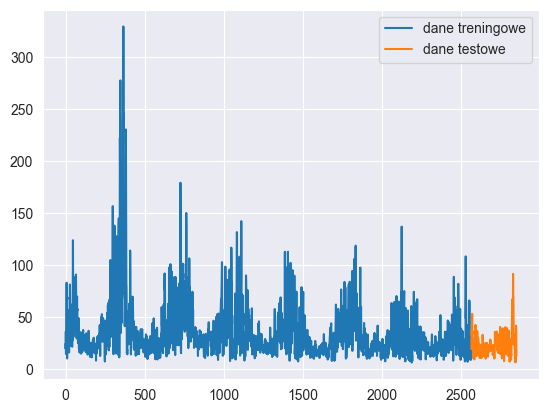

In [4]:
plt.plot(range(len(y_train)), y_train, label='dane treningowe')
plt.plot(range(len(y_train), len(y_train)+len(y_test)), y_test, label='dane testowe')
plt.legend()
plt.show()

### Random Forest

In [5]:
# random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree

In [6]:
regressor = RandomForestRegressor(n_estimators=200, random_state=44, oob_score=True, bootstrap=True)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [7]:
oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score:.4f}')
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2:.4f}')

Out-of-Bag Score: 0.6483
Mean Squared Error: 41.4424
R-squared: 0.6625


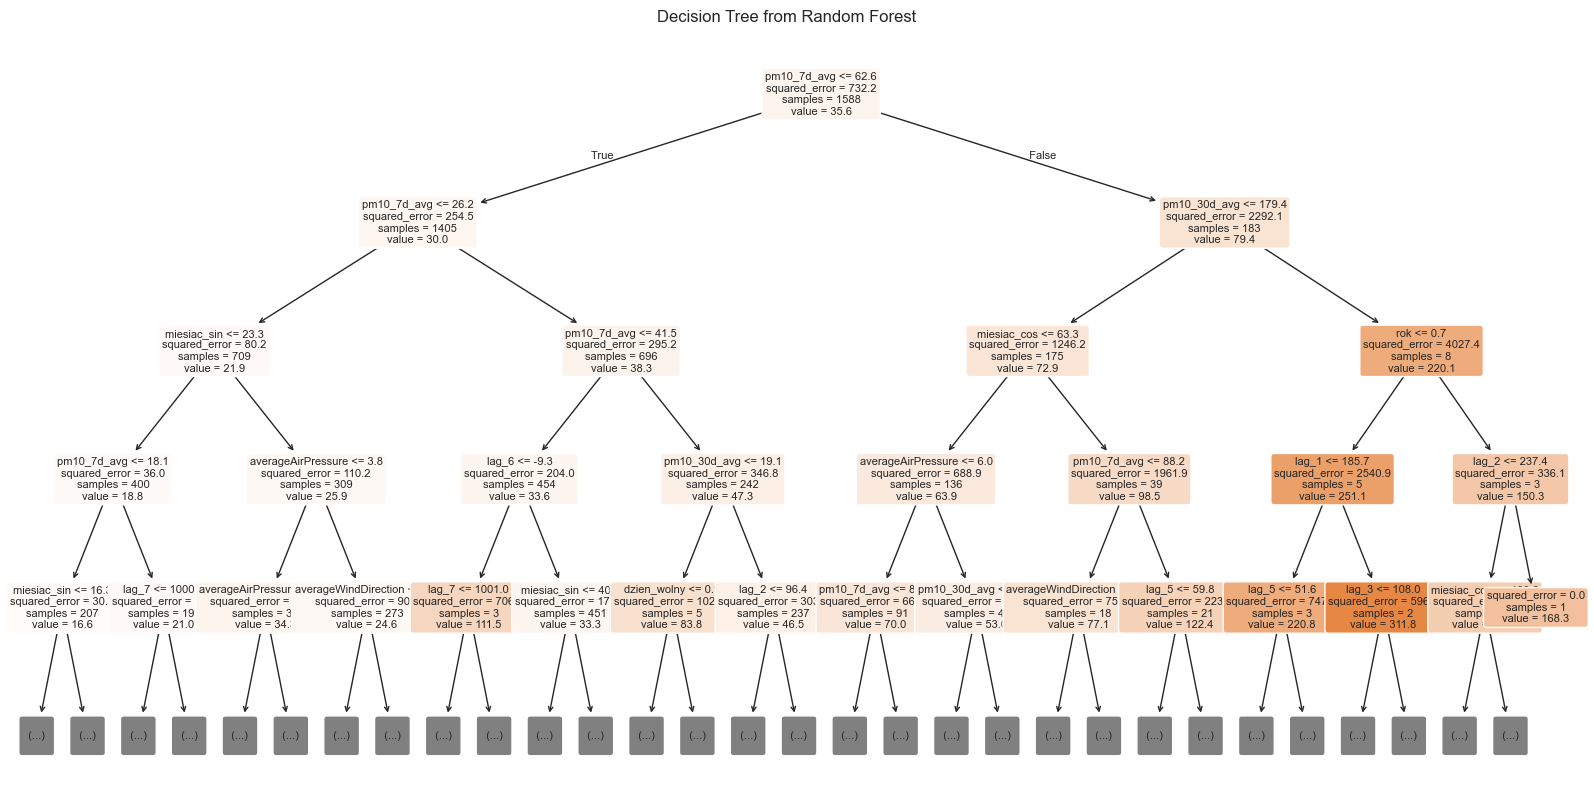

In [8]:
# Assuming regressor is your trained Random Forest model
# Pick one tree from the forest, e.g., the first tree (index 0)
tree_to_plot = regressor.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(tree_to_plot, feature_names=df.columns.tolist(), filled=True, rounded=True, fontsize=8, precision=1, max_depth=4)
plt.title("Decision Tree from Random Forest")
plt.show()

Model także ma wysoki błąd $MSE = 0.40$, ale już znacznie wyższy współczynnik $R^2$.
Zmiana parametrów pogarszała wyniki.
Wysokie błedy wynikają prawdopodobnie ze stosunkowo małego zbioru danych i braku silnych zależności z cechami - zwiększenie zbioru testowego poprawiło wyniki.

### XGBoost

In [9]:
import xgboost as xg 
from sklearn.model_selection import GridSearchCV

In [10]:
xgb_r = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 100, seed = 44) 
xgb_r.fit(X_train, y_train) 
y_pred = xgb_r.predict(X_test) 

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2:.4f}')

Mean Squared Error: 38.0736
R-squared: 0.6899


In [168]:
train_dmatrix = xg.DMatrix(data = X_train, label = y_train) 
test_dmatrix = xg.DMatrix(data = X_test, label = y_test) 

n_estimators = 300
param = {'objective': 'reg:squarederror', 
        'colsample_bytree': 0.95, # 1 the best
        'gamma': 0,
        'learning_rate': 0.05,
        'max_depth': 8,
        'reg_alpha': 0.015,
        'reg_lambda': 0.01,
        'subsample': 0.75}
xbg_rhp = xg.train(param, train_dmatrix, n_estimators)
y_pred = xbg_rhp.predict(test_dmatrix)

In [169]:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2:.4f}')

Mean Squared Error: 29.5772
R-squared: 0.7591


In [154]:
param_grid = {
    'learning_rate': [0.03, 0.05],
    'max_depth': [7, 8],
    'subsample': [0.75, 0.85],
    'reg_alpha': [0.01, 0.015],
    'reg_lambda': [0.01, 0.015],
    'gamma': [0, 0.02]
}
grid_search = GridSearchCV(estimator=xg.XGBRegressor(), param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=2)

In [155]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=2,
             param_grid={'gamma': [0, 0.02], 'learning_rate': [0.03, 0.05],
                         'max_depth': [7, 8], 'reg_alpha': [0.01, 0.015],
                         'reg_lambda': [0.01, 0.015],
                         'subsample': [0.75, 0.85]},
             scoring='neg_mean_squared_error', verbose=1)

In [156]:
grid_search.best_params_

{'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 8,
 'reg_alpha': 0.015,
 'reg_lambda': 0.01,
 'subsample': 0.75}

In [ ]:
y_pred = grid_search.best_estimator_(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2:.4f}')

XGBoost ma już niższy błąd $MSE = 0.29$, ale także zwiększył się współczynnik $R^2$.
Zmiana parametrów pogarszała wyniki.
Wysokie błedy wynikają prawdopodobnie ze stosunkowo małego zbioru danych i braku silnych zależności z cechami - zwiększenie zbioru testowego poprawiło wyniki. 